<a href="https://colab.research.google.com/github/as791/Adversarial-Example-Attack-and-Defense/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 391 Validation data: 79 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


##Attack

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    
    self.fc1 = nn.Linear(3136, 200)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(200, 200)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    #print(x.shape)
    #x = torch.flatten(x, 1)
    x = x.view(-1, 7*7*64) # Flattens to 1x7*7*64 row vector
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout1(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [8]:
model = Net().to(device)

In [9]:
#optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5, nesterov=True)

criterion = nn.NLLLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label.long())
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    #scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [11]:
loss,val_loss=fit(model,device,train_loader,val_loader,50)

Fitting the model...
Epoch: 1 Loss: 0.9628049052127486 Val_Loss: 0.16958297517952287
Epoch: 2 Loss: 0.13375569134474258 Val_Loss: 0.11263045407478002
Epoch: 3 Loss: 0.09047890933768829 Val_Loss: 0.12266842820504799
Epoch: 4 Loss: 0.07363281923029429 Val_Loss: 0.095240863771001
Epoch: 5 Loss: 0.06145818799834155 Val_Loss: 0.06680640649592763
Epoch: 6 Loss: 0.04832870452224141 Val_Loss: 0.06739575176682512
Epoch: 7 Loss: 0.04210840753080738 Val_Loss: 0.06697318314492137
Epoch: 8 Loss: 0.039513034007364355 Val_Loss: 0.06625813000564333
Epoch: 9 Loss: 0.03361498760928869 Val_Loss: 0.05914391600232147
Epoch: 10 Loss: 0.03196461089303755 Val_Loss: 0.06087017661149177
Epoch: 11 Loss: 0.02855163808528553 Val_Loss: 0.06756676096672522
Epoch: 12 Loss: 0.026217155236415293 Val_Loss: 0.06186829353211141
Epoch: 13 Loss: 0.024044983107355467 Val_Loss: 0.06587286522947959
Epoch: 14 Loss: 0.022061283257134887 Val_Loss: 0.06030648523540814
Epoch: 15 Loss: 0.020859765962672555 Val_Loss: 0.06329540333038

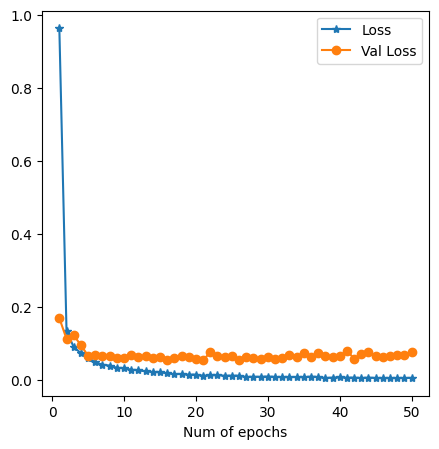

In [13]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,51), loss, "*-",label="Loss")
plt.plot(np.arange(1,51), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [12]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [14]:
def test(modelTest,modelAttack,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = modelAttack(data)
      loss = F.nll_loss(output, target)
      modelAttack.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (target.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

In [15]:
def test_model(model,device,test_loader):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() == target.item():
            correct += 1
        else:
            adv_ex = data.squeeze().detach().cpu().numpy()
            adv_examples.append((target.item(), init_pred.item(), adv_ex))
            
    final_acc = correct/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))
    
examples = test_model(model, device,test_loader)

Test Accuracy = 9919 / 10000 = 0.9919


In [16]:
#cnt = 0
#plt.figure(figsize=(20,15))
#for i in range(len(examples)//5):
#    for j in range(5):
#        cnt += 1
#        plt.subplot(len(examples)//5, 5, cnt)
#        plt.xticks([], [])
#        plt.yticks([], [])
#        orig,adv,ex = examples[cnt]
#        plt.title("{} -> {}".format(orig, adv))
#        plt.imshow(ex, cmap="gray")
#plt.tight_layout()
#plt.show()

Epsilon: 0.007	Test Accuracy = 9880 / 10000 = 0.988
Epsilon: 0.01	Test Accuracy = 9876 / 10000 = 0.9876
Epsilon: 0.02	Test Accuracy = 9838 / 10000 = 0.9838
Epsilon: 0.03	Test Accuracy = 9796 / 10000 = 0.9796
Epsilon: 0.05	Test Accuracy = 9707 / 10000 = 0.9707
Epsilon: 0.1	Test Accuracy = 9352 / 10000 = 0.9352
Epsilon: 0.2	Test Accuracy = 8475 / 10000 = 0.8475
Epsilon: 0.3	Test Accuracy = 7684 / 10000 = 0.7684


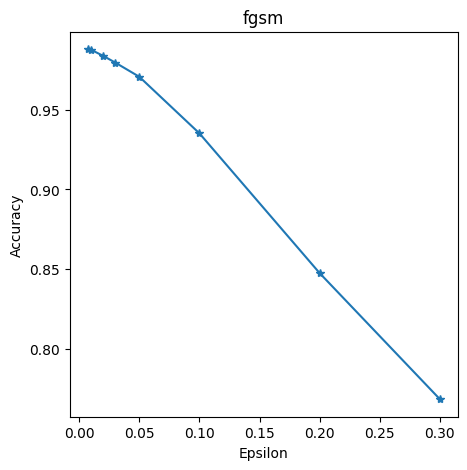

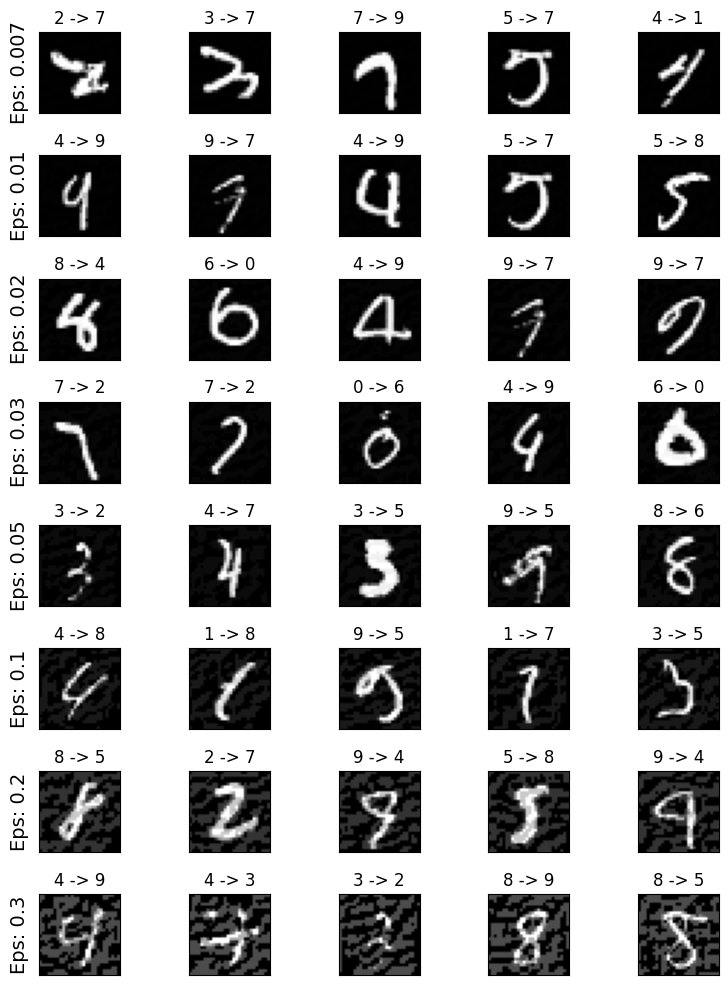

Epsilon: 0.007	Test Accuracy = 9886 / 10000 = 0.9886
Epsilon: 0.01	Test Accuracy = 9864 / 10000 = 0.9864
Epsilon: 0.02	Test Accuracy = 9846 / 10000 = 0.9846
Epsilon: 0.03	Test Accuracy = 9811 / 10000 = 0.9811
Epsilon: 0.05	Test Accuracy = 9722 / 10000 = 0.9722
Epsilon: 0.1	Test Accuracy = 9439 / 10000 = 0.9439
Epsilon: 0.2	Test Accuracy = 8627 / 10000 = 0.8627
Epsilon: 0.3	Test Accuracy = 7913 / 10000 = 0.7913


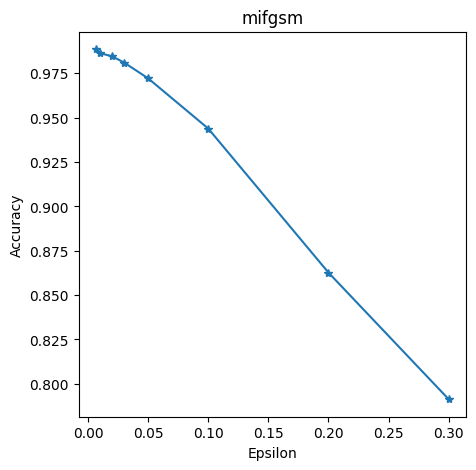

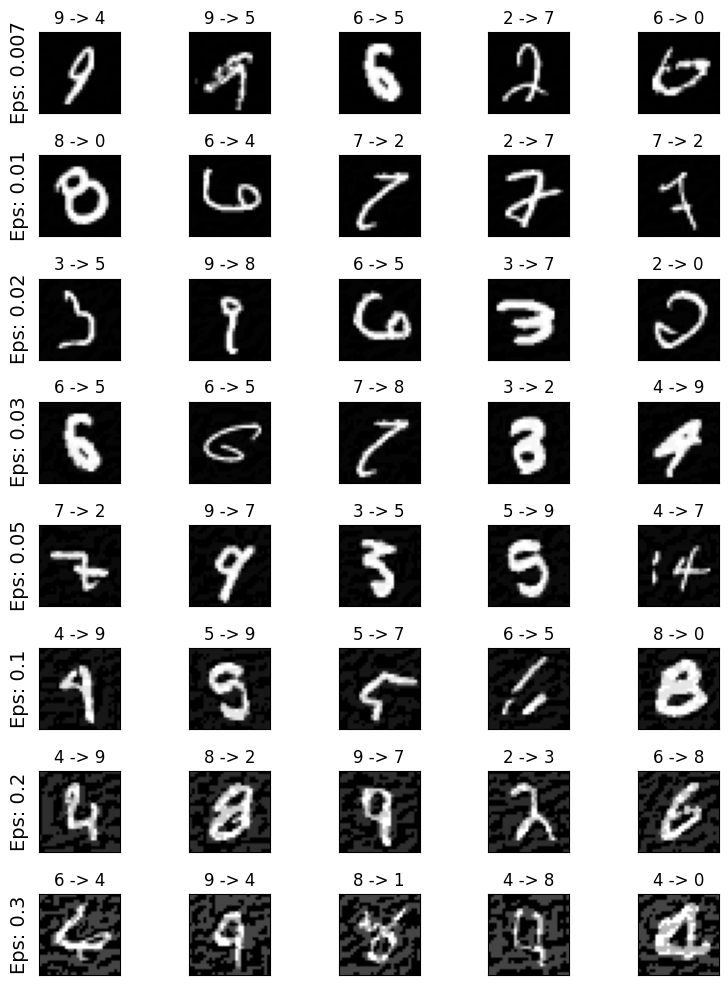

In [17]:
epsilons = [0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()